In [140]:
import time
import re
import math
from __future__ import print_function
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelBinarizer, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from scipy import sparse
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_log_error, make_scorer



# Ансамбли

import xgboost as xgb

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('mercari/train.tsv', sep='\t')

In [4]:
df.drop(['train_id'], axis=1, inplace=True)

In [5]:
df = df.sample(frac=0.15, random_state=1)

In [161]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['price'], axis=1), df['price'], test_size=0.25, random_state=42)

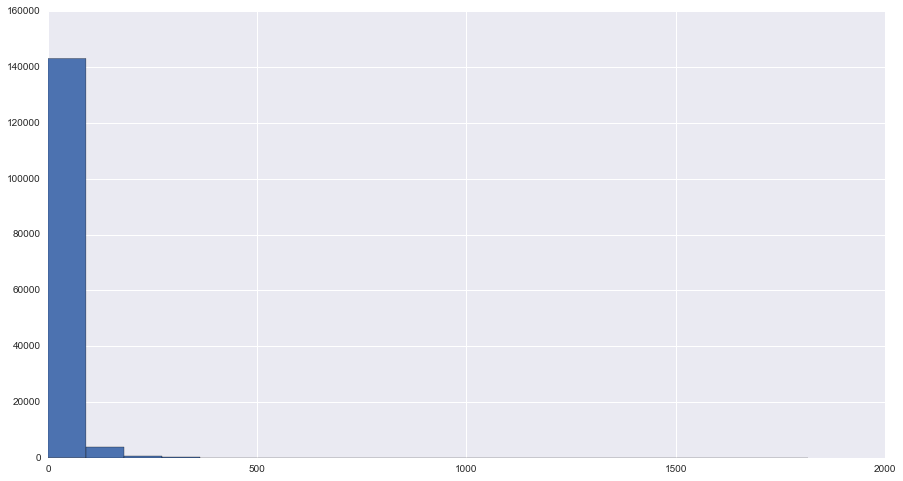

In [74]:
df.price.hist(bins=20)

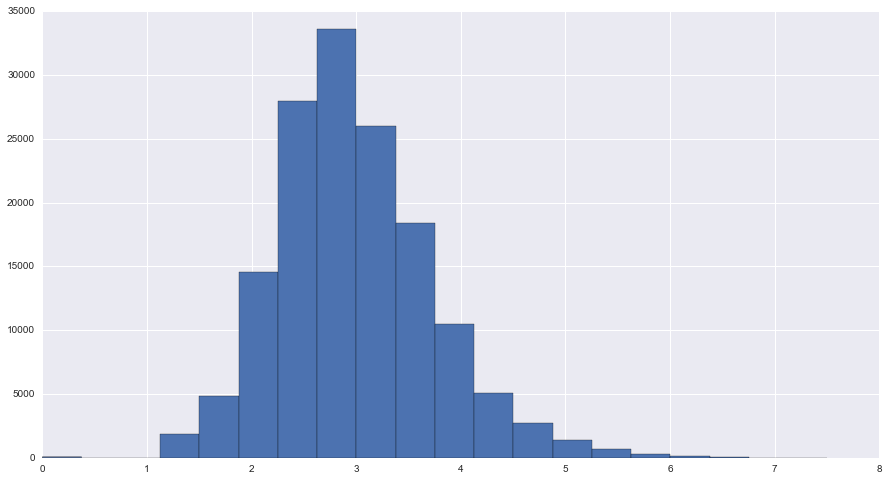

In [73]:
np.log(df.price + 1).hist(bins=20)

In [118]:
class CategoriesTransformer(BaseEstimator):
  
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X = X.copy()
        X['category_name'].fillna("MISSING/MISSING/MISSING", inplace=True)
        X['cat_1'], X['cat_2'], X['cat_3'] = zip(*X['category_name'].apply(lambda x: x.split("/")))
        X.drop(['category_name'], inplace=True, axis=1)
        return X
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [119]:
class CountTransformer(BaseEstimator):
    
    def __init__(self, feature):
        self.feature = feature
  
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X = X.copy()
        X[self.feature].fillna("MISSING", inplace=True)
        feature_dict = X[self.feature].value_counts().to_dict()
        X[self.feature + '_count'] = [feature_dict[f] for f in X[self.feature]]
        X.drop([self.feature], inplace=True, axis=1)
        return X
        
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [120]:
categories_transformer = CategoriesTransformer()
count_transformer = CountTransformer('brand_name')
si = SimpleImputer(strategy='constant', fill_value='MISSING')
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [121]:
init_pipeline = make_pipeline(categories_transformer, count_transformer)
cat_features_pipeline = make_pipeline(ohe)

In [122]:
def get_text_pipeline():
    cv = CountVectorizer(min_df=10, stop_words='english', ngram_range=(1, 2), max_features=10000)
    tfidf = TfidfTransformer()
    return make_pipeline(cv, tfidf)

In [137]:
def rmsle_f(y_test, predictions):
    return np.sqrt(mean_squared_log_error(y_test, predictions))

rmsle = make_scorer(rmsle_f)

In [151]:
def randomForest(ct):
    clf = RandomForestRegressor(n_estimators=100, max_features='sqrt', n_jobs=-1, max_depth=20)
    pipeline = make_pipeline(init_pipeline, ct, clf)
    cv_result = cross_validate(pipeline, X_train, y_train, cv=5, scoring=rmsle)
    return np.mean(cv_result['test_score'])

In [153]:
#baseline - учим на всем
transformers = [('ident', 'passthrough', ['shipping', 'brand_name_count']), 
                    ('cat', cat_features_pipeline, ['item_condition_id', 'cat_1', 'cat_2', 'cat_3']),
                   ('name', get_text_pipeline(), 'name'),
                   ('item_description', get_text_pipeline(), 'item_description')]

ct = ColumnTransformer(transformers=transformers)
print(randomForest(ct))

0.764469799131


In [152]:
#Учим без текста
transformers = [('ident', 'passthrough', ['shipping', 'brand_name_count']), 
                    ('cat', cat_features_pipeline, ['item_condition_id', 'cat_1', 'cat_2', 'cat_3'])]

ct = ColumnTransformer(transformers=transformers)
print(randomForest(ct))

0.748042282144


In [154]:
def xgboost_rmsle(predictions, dmat):
    labels = dmat.get_label()
    diffs = np.log(predictions + 1) - np.log(labels + 1)
    squared_diffs = np.square(diffs)
    avg = np.mean(squared_diffs)
    return ('RMSLE', np.sqrt(avg))

In [175]:
def xgboost(rounds, ct):
    pipeline = make_pipeline(init_pipeline, ct)

    dtrain = xgb.DMatrix(pipeline.fit_transform(X_train), label=y_train)
    clf = xgb.XGBRegressor(
                max_depth = 7,
                learning_rate=0.1, 
                subsample=0.5,
                n_jobs=-1,
                colsample_bytree=0.5,
                min_child_weight = 3)
    xgb_param = clf.get_xgb_params()
    return xgb.cv(xgb_param, dtrain, num_boost_round=rounds, feval=xgboost_rmsle, nfold=5)

In [ ]:
#XGBoost - лучшая модель
transformers = [('ident', 'passthrough', ['shipping', 'brand_name_count']), 
                    ('cat', cat_features_pipeline, ['item_condition_id', 'cat_1', 'cat_2', 'cat_3']),
                   ('name', get_text_pipeline(), 'name'),
                   ('item_description', get_text_pipeline(), 'item_description')]

ct = ColumnTransformer(transformers=transformers)
cv = xgboost(150, ct)

In [179]:
print(cv["test-RMSLE-mean"][150])

0.6603982


In [171]:
#XGBoost - без текста
transformers = [('ident', 'passthrough', ['shipping', 'brand_name_count']), 
                    ('cat', cat_features_pipeline, ['item_condition_id', 'cat_1', 'cat_2', 'cat_3'])]

ct = ColumnTransformer(transformers=transformers)
print(xgboost(ct)["test-RMSLE-mean"].tail(1))

99   0.67
Name: test-RMSLE-mean, dtype: float64


# Задание сделать
1. Сделать baseline submission
  * Исследовать признак price
  * Исследовать признак price в зависимости от brand_name или других признаков
2. Реализовать цикл анализа
  * признаки -> модель -> настройка параметров -> лучшая модель и ее значение метрики качества на кросс-валидации
3. Провести простые преобразования признаков и добавление простых признаков
  * разделить category_name на уровни
  * посмотреть на наличие числовых значений в описании и имени
4. Составить план по применению нескольких моделей на разных признаках
  * спроектируйте эксперимент. Нужно заранее спланировать порядок перебора признаков и моделей. Потом только писать код. Обратный порядок вызывает необходимость переписывать существующий код, это трата времени
5. Просмотреть 1-5 kernel на kaggle. (только в таком порядке. сначала работаем самостоятельно, потом смотрим идеи других. при появлении опыта можно сразу начинать с них)
6. Построить модель, выбрать лучшую
7. Построить ансамбль, настрить парамертры. Сравнить с другими моделями.
8. Оценить качество на CV.